In [84]:
import requests
import lxml.html

In [85]:
from xml.etree.ElementTree import *

In [86]:
r = requests.get("http://www.asahi-net.or.jp/~tk7m-ari/sazae_ichiran.html", verify=False)
requestEncode = r.encoding
request = r.text.encode(requestEncode)

In [88]:
re = str(request)
lis.append(re)
l=lis[0] 
ls = l.split("<BR>")

In [90]:
i = 0
lis = list()
for i in range(len(ls)):
    if 'x83O' in ls[i]:
        m = 'G'
        lis.append(m)
    if 'x83p' in ls[i]:
        m = 'P'
        lis.append(m)
    if 'x83L' in ls[i]:
        m = 'X'
        lis.append(m)
    else:
        pass

とりあえず過去1300回分全てのじゃんけんで出した手の分布を棒グラフにしてみます。

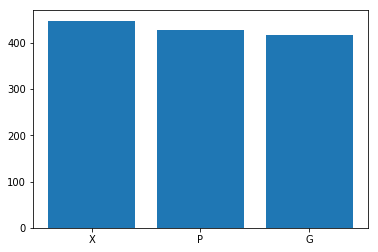

In [124]:
import pandas as pd
from pandas import DataFrame as df
dl = df(lis)
import matplotlib.pyplot as plt
J = ['X','P','G']
dl.columns = ['jj']
import numpy as np
dj = dl['jj'].value_counts()
dn = np.array(dj)
xs = [i  for i, _ in enumerate(J)]
plt.bar(xs, dn)
plt.xticks([i for i, _ in enumerate(J)], J)
plt.show()

どうやら長期間でみると、全部の手をほとんど同じくらい出しているようですね。若干X（チョキ)が多いようです。

次に、ここ１００回でみてみます。

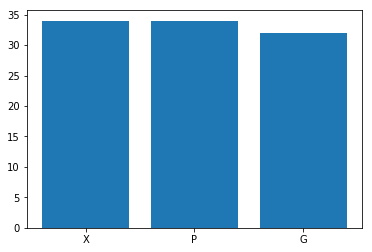

In [126]:
d2 = dl[0:100]
dj2 = d2['jj'].value_counts()
dn2 = np.array(dj2)
xs2 = [i  for i, _ in enumerate(J)]
plt.bar(xs2, dn2)
plt.xticks([i for i, _ in enumerate(J)], J)
plt.show()

100回スパンでみてもそんなに変わりませんね。なので、「ある1０回スパンで見たチョキを出した数とパーを出した数」の推移を見て見ましょう。

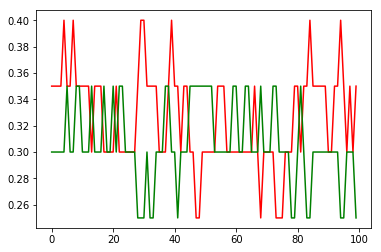

In [158]:
i = 0
lx = np.array([])
lp = np.array([])
for i in range(100):
    ls2 = lis[100-i:119-i]
    d2x = ls2.count('X')/20
    d2p = ls2.count('P')/20
    lx = np.append(d2x, lx)
    lp = np.append(d2p, lp)
xs2 = [i  for i, _ in enumerate(lx)]
plt.plot(xs2, lx, 'r-', label = 'choki')
plt.plot(xs2, lp, 'g-', label = 'pa')
plt.show()

折れ線がわかりにくかったので、散布図に切り替えます。

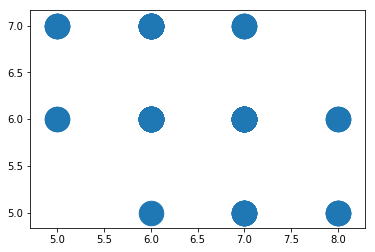

In [164]:
i = 0
lx = np.array([])
lp = np.array([])
for i in range(100):
    ls2 = lis[100-i:119-i]
    d2x = ls2.count('X')
    d2p = ls2.count('P')
    lx = np.append(d2x, lx)
    lp = np.append(d2p, lp)
xs2 = [i  for i, _ in enumerate(lx)]
plt.scatter(lx,lp,s=600)
plt.axis('equal')
plt.show()

２０回スパンで見ても、大きく一つの手が増えるということはありました。（チョキだけで１０回、みたいな）

### ここまでで、「中長期でみると３つの手をほとんど同じだけ出す」ことがわかりました。ここから、直前の手に注目して分析して見ます。

とりあえず、ここ200回に注目して、3×3の行列を作ります。

In [176]:
lb = np.zeros(9)
J = ['X','P','G']
ls3 = lis[:200]
i = 0
q = 0
a = 0
for i in range(3):
    for q in range(3):
        for a in range(len(ls3)-1):
            b = ls3[199-a]
            if J[i] in b:
                c = ls3[198-a]
                if J[q] in c:
                    lb[3*i+q] = lb[3*i+q]+1
            else:
                pass
lb

array([ 11.,  29.,  29.,  32.,  12.,  22.,  26.,  24.,  14.])

In [177]:
lb = np.zeros((3,3))
J = ['X','P','G']
ls3 = lis[:200]
i = 0
q = 0
a = 0
for i in range(3):
    for q in range(3):
        for a in range(len(ls3)-1):
            b = ls3[199-a]
            if J[i] in b:
                c = ls3[198-a]
                if J[q] in c:
                    lb[i][q] = lb[i][q]+1
            else:
                pass
lb

array([[ 11.,  29.,  29.],
       [ 32.,  12.,  22.],
       [ 26.,  24.,  14.]])

In [178]:
lb2 = np.zeros((3,3))
J = ['X','P','G']
ls3 = lis[:500]
i = 0
q = 0
a = 0
for i in range(3):
    for q in range(3):
        for a in range(len(ls3)-1):
            b = ls3[499-a]
            if J[i] in b:
                c = ls3[498-a]
                if J[q] in c:
                    lb2[i][q] = lb2[i][q]+1
            else:
                pass
lb2

array([[ 24.,  75.,  73.],
       [ 79.,  35.,  55.],
       [ 69.,  58.,  31.]])

これは、「J = ['X','P','G']を出した次に何を出したか」の行列で、これにより、(1)次の手は前の手に勝つような手を出す確率が高く(2)前の手と同じ手はあまり出さない、ことがわかる。ただし、グーを出した次の手に関してはパーよりもチョキを出す確率が高いようだ。

ここから、機械学習を利用して、次に出る手を予測するモデルを作り、精度をvalidationによって確かめたい。

まず、決定木のコードの練習をしてみる。

In [4]:
def visualize_tree(classifier, X, y, boundaries=True,xlim=None, ylim=None):
    """決定木の可視化関数。
    INPUTS: 分類モデル, X, y, optional x/y limits.
    OUTPUTS: Meshgridを使った決定木の可視化
    """
    # fitを使ったモデルの構築
    classifier.fit(X, y)

    # 軸を自動調整
    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim


    # meshgridをつくる。
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),np.linspace(y_min, y_max, 100))

    # 分類器の予測を実行
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # meshgridを使って整形。
    Z = Z.reshape(xx.shape)

    # 分類ごとに色付け。
    plt.figure(figsize=(10,10))
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='jet')

    # 訓練データの描画。
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        

    def plot_boundaries(i, xlim, ylim):
        '''
        境界線を描き込みます。
        '''
        if i < 0:
            return

        tree = classifier.tree_

        # 境界を描画するために、再帰的に呼び出します。
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i], [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i], [tree.threshold[i], xlim[1]], ylim)

        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])

    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

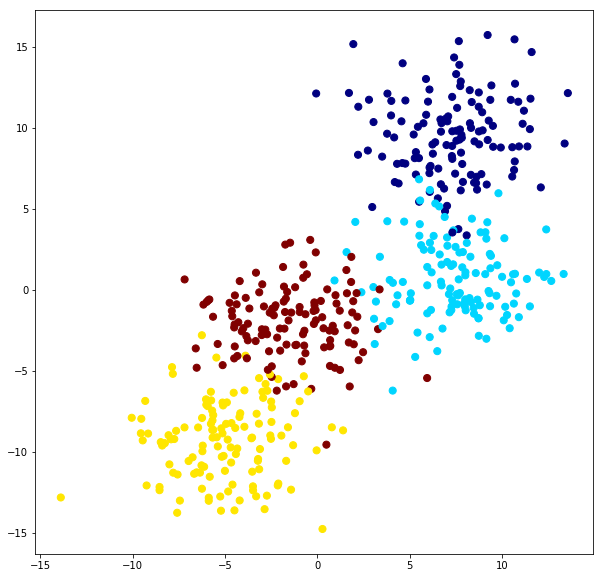

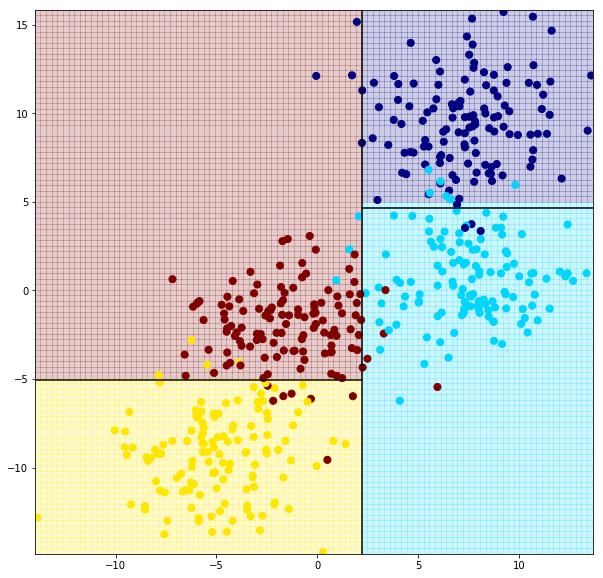

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

from sklearn.datasets import make_blobs # ダミーデータの生成用
X, y = make_blobs(n_samples=500, centers=4, random_state=8, cluster_std=2.4)
plt.figure(figsize =(10,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')
from sklearn.tree import DecisionTreeClassifier             # 決定木用
clf = DecisionTreeClassifier(max_depth=2, random_state = 0) # インスタンス作成 max_depth:木の深さ

visualize_tree(clf, X, y)    # 描画実行

<Container object of 3 artists>

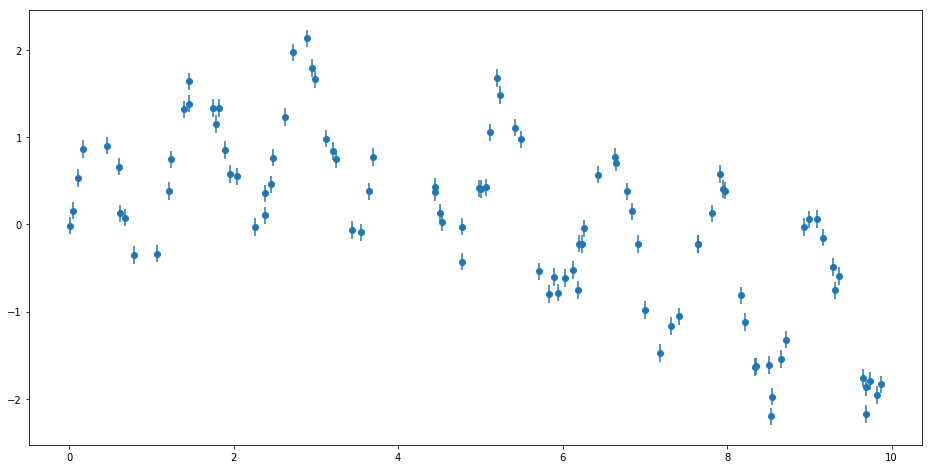

In [6]:
from sklearn.ensemble import RandomForestRegressor

x = 10 * np.random.rand(100)

def sin_model(x, sigma=0.2):
    """大きな波＋小さな波＋ノイズからなるダミーデータ。"""
    noise = sigma * np.random.randn(len(x))

    return np.sin(5 * x) + np.sin(0.5 * x) + noise

# xからyを計算
y = sin_model(x)

# Plotしてみる。
plt.figure(figsize=(16,8))
plt.errorbar(x, y, 0.1, fmt='o')

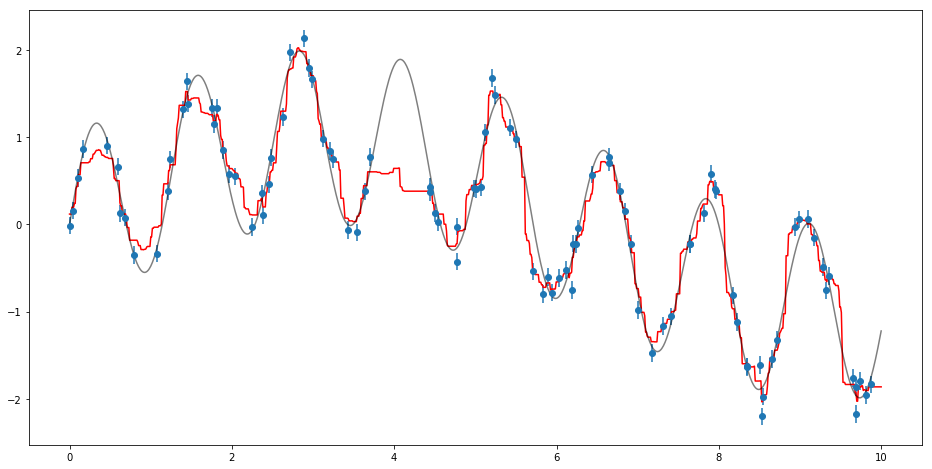

In [7]:
from sklearn.ensemble import RandomForestRegressor # ランダムフォレスト回帰用

# 確認用に0〜10の1000個のデータを用意
xfit = np.linspace(0, 10, 1000)       #0〜10まで1000個

# ランダムフォレスト実行
rfr = RandomForestRegressor(100)  # インスタンスの生成　木の数を100個に指定
rfr.fit(x[:, None], y)            # 学習実行
yfit = rfr.predict(xfit[:, None]) # 予測実行

# 結果比較用に実際の値を取得。
ytrue = sin_model(xfit,0) # xfitを波発生関数に食わせて、その結果を取得

# 結果確認
plt.figure(figsize = (16,8))
plt.errorbar(x, y, 0.1, fmt='o')
plt.plot(xfit, yfit, '-r')                # 予測値のplot
plt.plot(xfit, ytrue, '-k', alpha = 0.5)  # 正解値のplot